In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from collections import deque
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

# FUNCTIONS

In [2]:
def create_qaoa_circ(G, theta):
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

In [3]:
def maxcut_obj(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj += 1
            
    return obj

In [4]:
def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count -= count
        
    return avg/sum_count

In [5]:
def get_expectation(G):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """

    backend = QasmSimulator()

    def execute_circ(theta, draw=False):
        qc = create_qaoa_circ(G, theta)
        qc_compiled = transpile(qc, backend, optimization_level=3)
        job_sim = backend.run(qc_compiled, shots=1024*2**3)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(qc_compiled)
        if draw:
            sorted_counts = {key:counts[key] for key in sorted(counts.keys())}
            plt.figure(figsize=(10, 5), dpi=80)
            names = list(sorted_counts.keys())
            values = list(sorted_counts.values())

            plt.bar(range(len(sorted_counts)), values, tick_label=names)
            plt.show()

        return compute_expectation(counts, G)
    
    return execute_circ

# GRAPH

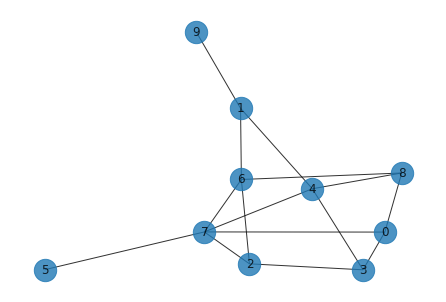

In [8]:
# G = nx.Graph()
# G.add_nodes_from([0, 1, 2, 3])
# G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
G = nx.gnp_random_graph(10, 0.3)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

# SCIPY optimization

In [9]:
from scipy.optimize import minimize


expectation = get_expectation(G)

res = minimize(expectation, [1.0, 1.0], method='COBYLA')
res

     fun: -8.173583984375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 35
  status: 1
 success: True
       x: array([1.18809835, 1.27816247])

In [17]:
backend = QasmSimulator()
qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10, shots=1024).result().get_counts()

for item in sorted(counts.items(), key=lambda item: item[1])[-8:]:
    print(f'{item[0]}:\n  count: {item[1]}, max cut score: {maxcut_obj(item[0], G)} ')

1011010000:
  count: 8, max cut score: 6 
0000100111:
  count: 8, max cut score: 9 
1000110101:
  count: 9, max cut score: 8 
0011011010:
  count: 10, max cut score: 8 
1110011000:
  count: 10, max cut score: 10 
1111011000:
  count: 12, max cut score: 9 
0111001010:
  count: 14, max cut score: 8 
1000100101:
  count: 17, max cut score: 9 


# CEM optimization

In [11]:
def cem(n_iterations=30, print_every=5, pop_size=50, elite_frac=0.2, calculate=None):
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = [1, 0]
    mean = [1, 1]
    cov = [[1, 0], [0, 1]] 
    for i_iteration in range(1, n_iterations+1):
        points = np.random.multivariate_normal(mean, cov, size=pop_size)
        points = np.concatenate((points, [best_weight]), axis=0)
        # ys = np.random.normal(y_mean, 0.04, size=50)
        # print(weights_pop)
        rewards = np.array([calculate([x, y]) for x, y in points])

        elite_idxs = rewards.argsort()[:n_elite]
        elite_weights = [points[i] for i in elite_idxs]

        # print(elite_weights)
        best_weight = elite_weights[0]

        reward = calculate(best_weight)
        scores_deque.append(reward)
        scores.append(reward)
        mean = np.mean(elite_weights, axis=0)
        cov = np.cov(np.stack((elite_weights), axis = 1))

        if i_iteration % print_every == 0:
            print(mean)
            print(cov)
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))
            print(f'{best_weight} with reward: {calculate(best_weight, True)}')
    # calculate(best_weight, True)
    return scores, best_weight


[ 1.76210237 -0.45180193]
[[ 0.05266017 -0.10239192]
 [-0.10239192  0.3075822 ]]
Episode 5	Average Score: -8.14


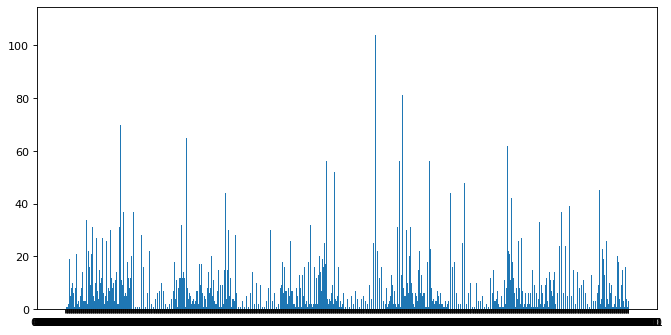

[ 1.90456224 -1.17750524] with reward: -8.1417236328125
[ 1.93804918 -1.2283717 ]
[[ 0.00137658 -0.00046194]
 [-0.00046194  0.00155837]]
Episode 10	Average Score: -8.15


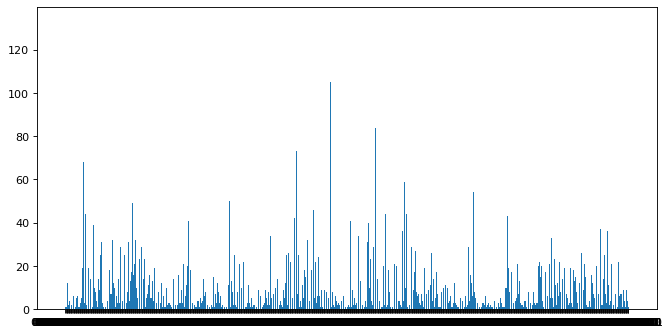

[ 1.97426082 -1.28378543] with reward: -8.154052734375
[ 1.9230983  -1.24913106]
[[ 2.75406444e-04 -8.74948040e-05]
 [-8.74948040e-05  9.14373455e-05]]
Episode 15	Average Score: -8.16


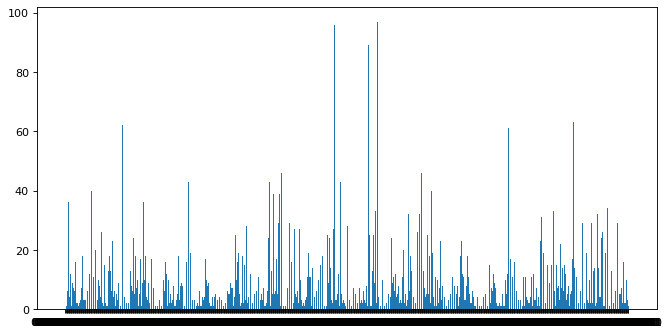

[ 1.90779074 -1.24314187] with reward: -8.1712646484375
[ 1.9281248  -1.24059508]
[[ 8.51700988e-05 -1.22422042e-05]
 [-1.22422042e-05  1.60673320e-05]]
Episode 20	Average Score: -8.16


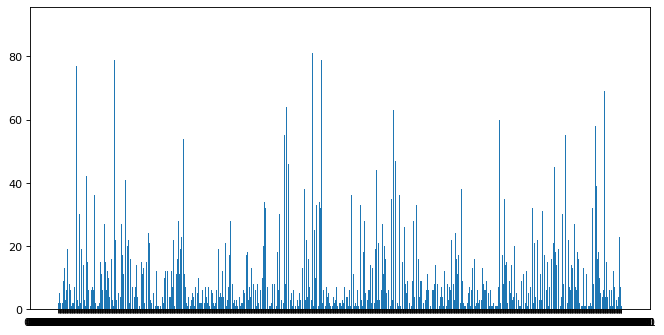

[ 1.92887122 -1.24502357] with reward: -8.1798095703125
[ 1.93134304 -1.24318022]
[[ 2.90596709e-05 -9.91067490e-06]
 [-9.91067490e-06  3.90734237e-06]]
Episode 25	Average Score: -8.16


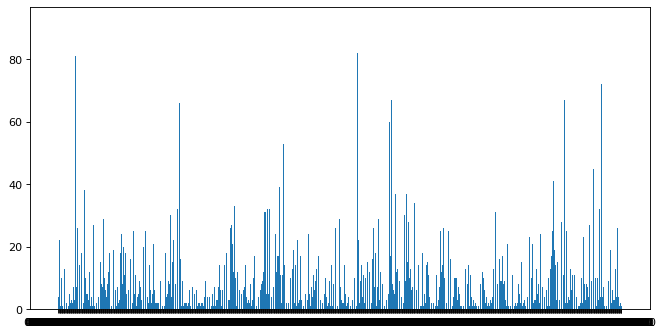

[ 1.93032219 -1.24389563] with reward: -8.1397705078125
[ 1.93456198 -1.2441518 ]
[[ 1.15331894e-05 -3.18789070e-06]
 [-3.18789070e-06  1.05933957e-06]]
Episode 30	Average Score: -8.16


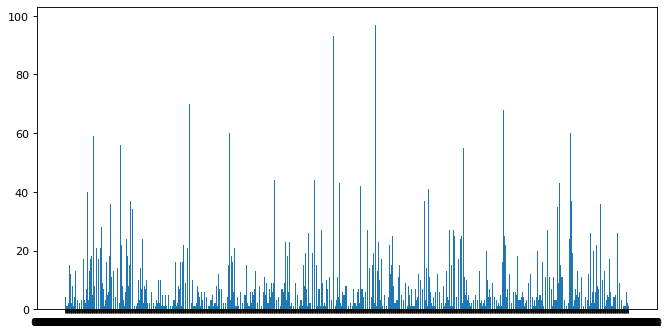

[ 1.93367239 -1.24394269] with reward: -8.159912109375


In [12]:
scores, best_weight = cem(calculate=expectation)

In [14]:
backend = QasmSimulator()
qc_res = create_qaoa_circ(G, best_weight)

counts = backend.run(qc_res, seed_simulator=10, shots=1024).result().get_counts()

for item in sorted(counts.items(), key=lambda item: item[1])[-8:]:
    print(f'{item[0]}:\n  count: {item[1]}, max cut score: {maxcut_obj(item[0], G)} ')

0111011010:
  count: 9, max cut score: 9 
1001101001:
  count: 9, max cut score: 11 
0000110111:
  count: 9, max cut score: 8 
1110011000:
  count: 9, max cut score: 10 
0000100111:
  count: 10, max cut score: 9 
0111001010:
  count: 12, max cut score: 8 
1111011000:
  count: 13, max cut score: 9 
1000100101:
  count: 16, max cut score: 9 
